## 多层全连接神经网络实现 MNIST 手写数字分类

$Talk$ $is$ $cheap$, $show$ $me$ $the$ $code$.      Harrytsz

### 一、定义模型：

>1.简单的三层全连接神经网络    
>2.添加激活函数的神经网络    
>3.添加批标准化的神经网络   

引入包：

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

定义超参数：

In [2]:
batch_size = 64
learning_rate = 1e-2
num_epoches = 20

下载数据并转换：

In [3]:
import numpy as np

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

# 使用内置函数下载 MNIST 数据集
train_set = datasets.MNIST('./data', train=True, transform=data_tf, download=True)
test_set = datasets.MNIST('./data', train=False, transform=data_tf, download=True)

定义数据迭代器：

In [4]:
# 使用 pytorch 自带的 DataLoader 定义数据迭代器
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#### 1.简单的三层全连接神经网络

In [5]:
class simpleNet(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, out_dim):
        super(simpleNet, self).__init__()
        self.layer1 = nn.Linear(in_dim, hidden_1)
        self.layer2 = nn.Linear(hidden_1, hidden_2)
        self.layer3 = nn.Linear(hidden_2, out_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [6]:
model0 = simpleNet(28*28, 30, 100, 10)nn.ReLU(True)

In [11]:
if torch.cuda.is_available():
    model = model0.cuda()
else:
    model = model0

#### 2.添加激活函数的神经网络

In [5]:
class ActivNet(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, out_dim):
        super(ActivNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_1),
            nn.ReLU(True)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(True)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_2, out_dim),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [6]:
model1 = ActivNet(28*28, 30, 100, 10)

In [7]:
if torch.cuda.is_available():
    model = model1.cuda()
else:
    model = model1

#### 3.添加批标准化的神经网络

In [7]:
class BatchNet(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, out_dim):
        super(BatchNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_1),
            nn.BatchNorm1d(hidden_1),
            nn.ReLU(True)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_1, hidden_2),
            nn.BatchNorm1d(hidden_2),
            nn.ReLU(True)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_2, out_dim)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [8]:
model2 = BatchNet(28*28, 30, 100, 10)

In [9]:
if torch.cuda.is_available():
    model = model2.cuda()
else:
    model = model2

## 二、定义损失函数和优化方法

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 三、训练网络和预测

In [11]:
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    
    # 训练模型
    for img, label in train_loader:
        if torch.cuda.is_available():
            img = Variable(img).cuda()
            label = Variable(label).cuda()
        else:
            img = Variable(img)
            label = Variable(label)
        
        # Forward
        out = model(img)
        loss = criterion(out, label)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record Loss
        train_loss += loss.item()
        
        # Compute classfication acc
        _, pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    model.eval()  # 将模型改为预测模式
    for img, label in test_loader:
        if torch.cuda.is_available():
            img = Variable(img).cuda()
            label = Variable(label).cuda()
        else:
            img = Variable(img)
            label = Variable(label)
        
        out = model(img)
        loss = criterion(out, label)
        
        # Record Loss
        eval_loss += loss.item()
        
        # Record predict acc
        _, pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('Epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
         .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader),
         eval_loss / len(test_loader), eval_acc / len(test_loader)))
    

Epoch: 0, Train Loss: 0.880276, Train Acc: 0.816031, Eval Loss: 0.337854, Eval Acc: 0.924761
Epoch: 1, Train Loss: 0.305169, Train Acc: 0.908815, Eval Loss: 0.224991, Eval Acc: 0.929737
Epoch: 2, Train Loss: 0.204296, Train Acc: 0.937816, Eval Loss: 0.194027, Eval Acc: 0.937500
Epoch: 3, Train Loss: 0.172491, Train Acc: 0.947994, Eval Loss: 0.200835, Eval Acc: 0.936007
Epoch: 4, Train Loss: 0.150117, Train Acc: 0.954907, Eval Loss: 0.166577, Eval Acc: 0.947054
Epoch: 5, Train Loss: 0.135871, Train Acc: 0.958239, Eval Loss: 0.143080, Eval Acc: 0.955812
Epoch: 6, Train Loss: 0.125057, Train Acc: 0.962487, Eval Loss: 0.149453, Eval Acc: 0.953125
Epoch: 7, Train Loss: 0.116804, Train Acc: 0.964269, Eval Loss: 0.154396, Eval Acc: 0.952727
Epoch: 8, Train Loss: 0.110733, Train Acc: 0.966485, Eval Loss: 0.167499, Eval Acc: 0.951632
Epoch: 9, Train Loss: 0.104194, Train Acc: 0.967984, Eval Loss: 0.142595, Eval Acc: 0.956907
Epoch: 10, Train Loss: 0.099830, Train Acc: 0.969566, Eval Loss: 0.137

## 四、可视化

画出 loss 曲线和准确率曲线

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

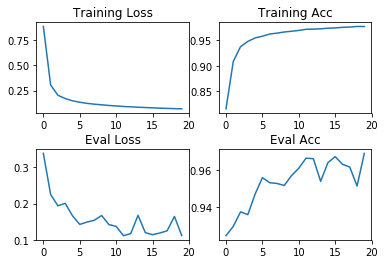

In [13]:
plt.figure()
plt.subplot(221)
plt.title('Training Loss')
plt.plot(np.arange(len(losses)), losses)
 
plt.subplot(222)
plt.title('Training Acc')
plt.plot(np.arange(len(acces)), acces)
 
plt.subplot(223)
plt.title('Eval Loss')
plt.plot(np.arange(len(eval_losses)), eval_losses)

plt.subplot(224)
plt.title('Eval Acc')
plt.plot(np.arange(len(eval_acces)), eval_acces)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.4)

plt.show()
 